<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
## Open Machine Learning Course
<center>Author: [Yury Kashnitsky](http://yorko.github.io). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center>Topic 9. Time series analysis with Python</center>
## <center>Analyzing accidental deaths in US with ARIMA</center>

[Introduction to ARIMA](https://www.youtube.com/watch?v=Y2khrpVo6qI).


We know monthly numbers of accidental deaths in the US from January 1973 till December 1978. Let's build predictions for next 2 years.

In [78]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

**Read and plot data. We can clearly notice seasonality.**

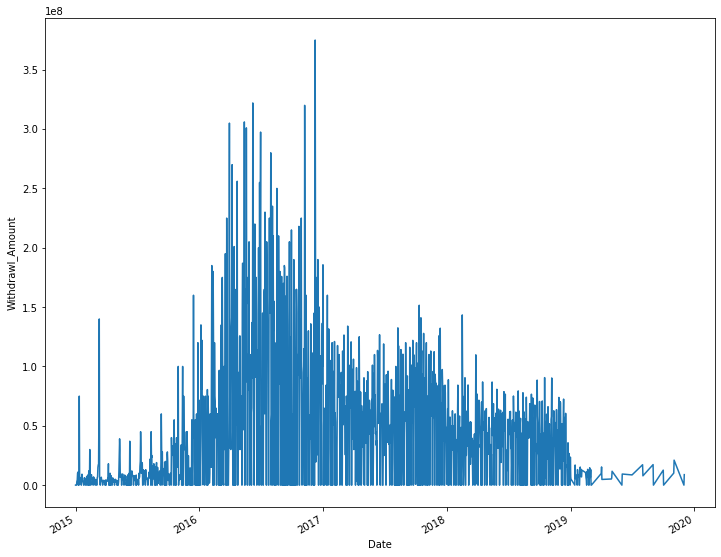

In [79]:
dataset = pd.read_csv('time_series_data.csv',
                   index_col=['Date'], parse_dates=['Date'])
#deaths.rename(columns={'Accidental deaths in USA: monthly, 1973 ? 1978': 'num_deaths'}, inplace=True)
dataset['Withdrawl_Amount'].plot()
plt.ylabel('Withdrawl_Amount');

In [80]:
dataset.tail(10)

,Withdrawl_Amount
Date,
2019-02-24,0.00
2019-02-25,10984120.00
2019-02-26,14615320.90
2019-02-27,10875000.00
2019-02-28,6498321.00
2019-01-03,4532396.00
2019-02-03,12633316.00
2019-03-03,0.00
2019-04-03,4800000.00


1. **Checking stationarity and performing STL decomposition ([Seasonal and Trend decomposition using Loess](https://otexts.org/fpp2/stl.html))**

Dickey-Fuller criterion: p=0.358286


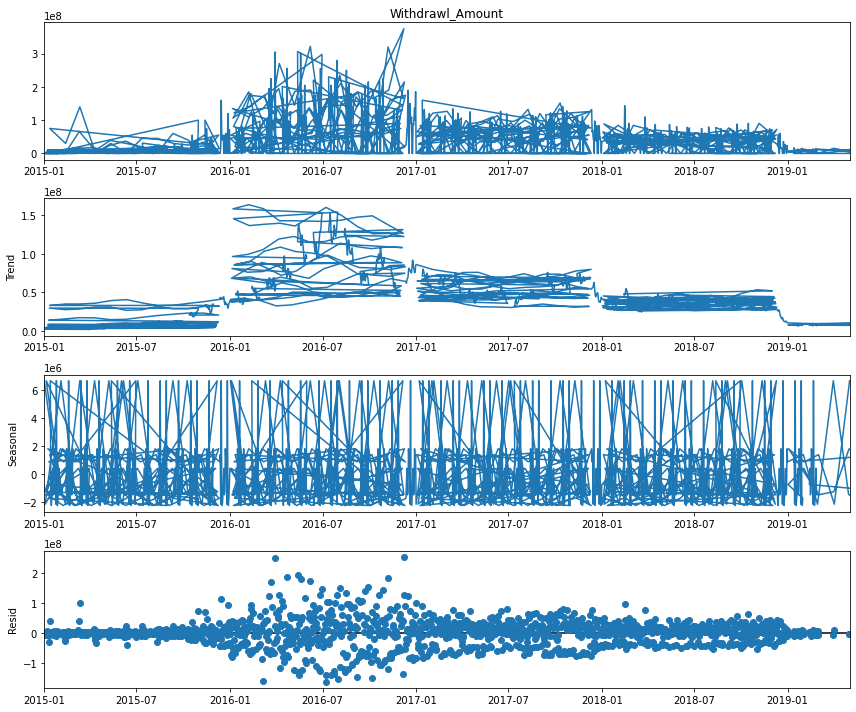

In [81]:
sm.tsa.seasonal_decompose(dataset['Withdrawl_Amount'],period=12).plot()
print("Dickey-Fuller criterion: p=%f" % 
      sm.tsa.stattools.adfuller(dataset['Withdrawl_Amount'])[1])

### Stationarity

Dickey-Fuller criteriom does not reject the non-stationarity null-hypothesis, but we still see a trend. Let's perform seasonal differentiation, then check again stationarity and perform STL decomposition:

Dickey-Fuller criterion: p=0.346267


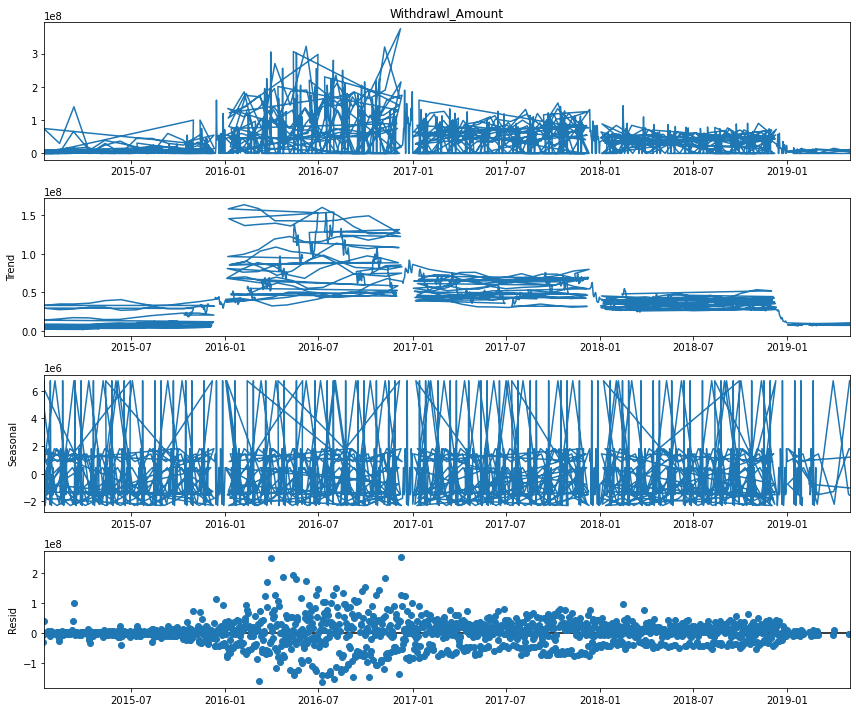

In [82]:
dataset['Withdrawl_Amount_diff'] = dataset['Withdrawl_Amount'] - \
                            dataset['Withdrawl_Amount'].shift(12)
sm.tsa.seasonal_decompose(dataset['Withdrawl_Amount'][12:],period=12).plot()
print("Dickey-Fuller criterion: p=%f" % 
      sm.tsa.stattools.adfuller(dataset['Withdrawl_Amount'][12:])[1])

Dickey-Fuller criteriom does now rejects the non-stationarity null-hypothesis, but we still see a trend. Let's now perform one more differentiation.

Dickey-Fuller criterion: p=0.000000


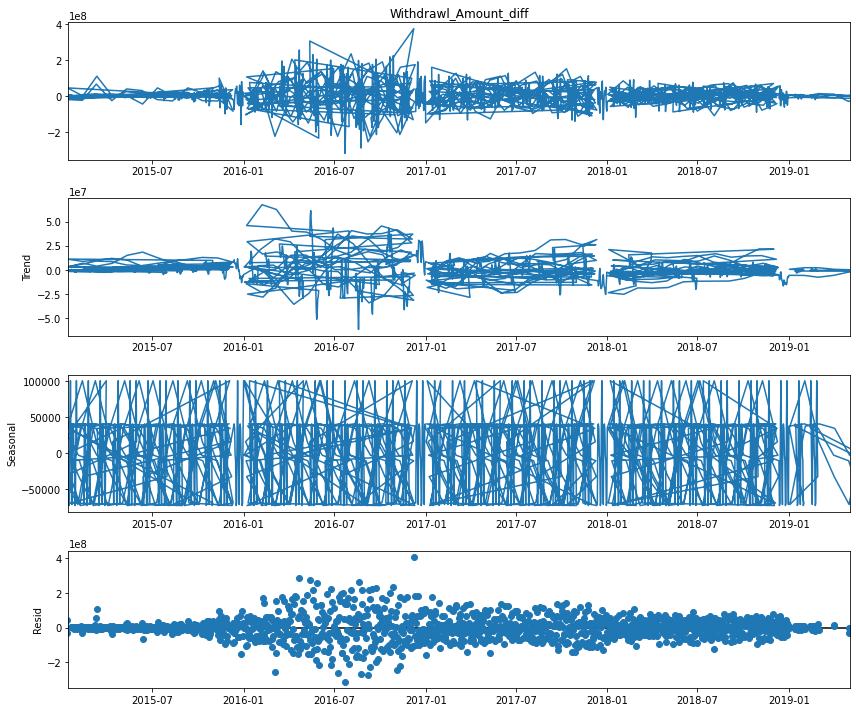

In [83]:
dataset['Withdrawl_Amount_diff2'] = dataset['Withdrawl_Amount_diff'] - \
                             dataset['Withdrawl_Amount_diff'].shift(1)
sm.tsa.seasonal_decompose(dataset['Withdrawl_Amount_diff'][13:],period=12).plot()
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(dataset['Withdrawl_Amount_diff'][13:])[1])

Non-stationarity hypothesis is now rejected, and graphs look all right, no trend anymore.

## Model selection

Let's build ACF and PACF for our time series (seems that there's a bug in PACF, it can't be >1):

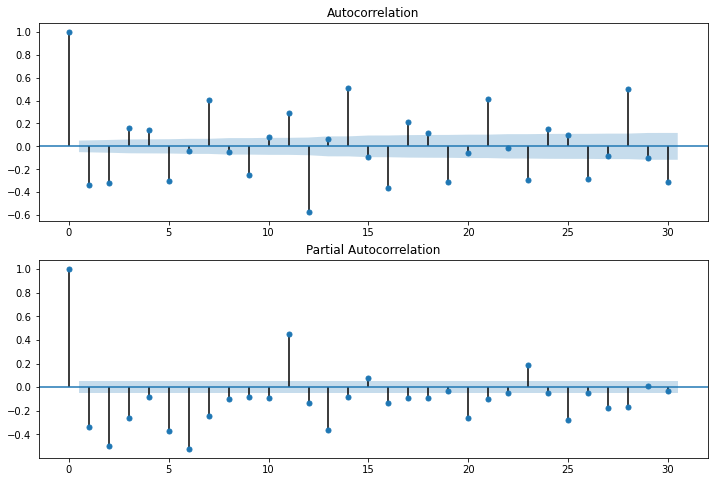

In [84]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(dataset['Withdrawl_Amount_diff2'][13:].values.squeeze(), 
                         lags=30, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(dataset['Withdrawl_Amount_diff2'][13:].values.squeeze(), 
                          lags=30, ax=ax);

Initial values: Q=2, q=1, P=2, p=2.
Setting these is not obligatory, but if we do so, we'll perform less computations tuning hyperparams.

In [85]:
ps = range(0, 3)
d=1
qs = range(0, 1)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [86]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

27

In [87]:
%%time
results = []
best_aic = float("inf")

warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except is needed because some parameter combinations are not valid
    try:
        model=sm.tsa.statespace.SARIMAX(dataset['Withdrawl_Amount_diff'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, 
                                                        param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # save best model, it's AIC and params
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 2min 41s


In [88]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
5   (0, 0, 1, 2)  59292.080276
8   (0, 0, 2, 2)  59311.502101
7   (0, 0, 2, 1)  59340.561181
4   (0, 0, 1, 1)  59538.284843
26  (2, 0, 2, 2)  59563.386713


Best model:

In [89]:
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                   Withdrawl_Amount_diff   No. Observations:                 1525
Model:             SARIMAX(0, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood              -29642.040
Date:                                 Wed, 28 Oct 2020   AIC                          59292.080
Time:                                         19:18:11   BIC                          59313.365
Sample:                                              0   HQIC                         59300.006
                                                - 1525                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0920      0.057     -1.601      0.109      -0.205       0

Its residuals:

Student's criterion: p=0.991545
Dickey-Fuller criterion: p=0.000000


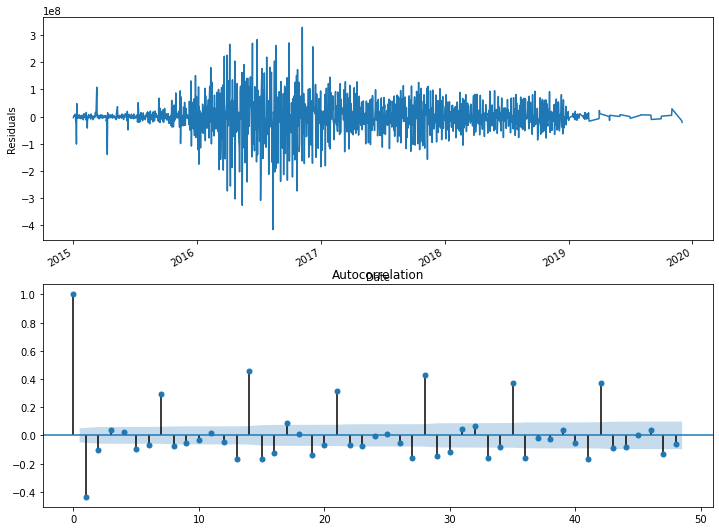

In [90]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Residuals are not biased (confirmed by the Student's criterion), are stationary (confirmed by the Dickey-Fuller criterion) and not auto-correlated (confirmed by the Ljung-Box criterion and correlogram).
Let's see how well the model fits data:

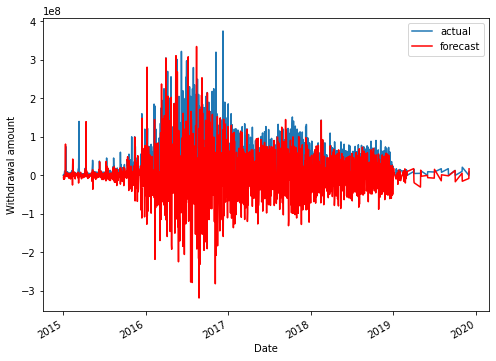

In [91]:
plt.figure(figsize=(8, 6))
dataset['model'] = best_model.fittedvalues
dataset['Withdrawl_Amount'].plot(label='actual')
dataset['model'][13:].plot(color='r', label='forecast')
plt.ylabel('Withdrawal amount')
plt.legend();

### Forecast

C:\softwares\anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


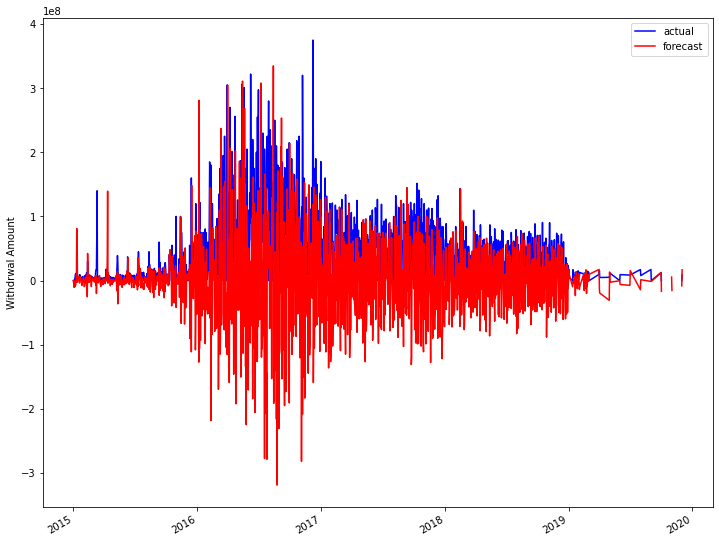

In [98]:
from dateutil.relativedelta import relativedelta
#deaths2 = deaths[['num_deaths']]
dataset2 = dataset[['Withdrawl_Amount']]
date_list = [pd.datetime.strptime("2019-10-03", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,32)]
future = pd.DataFrame(index=date_list, columns=dataset2.columns)
dataset2 = pd.concat([dataset2, future])
dataset2['forecast'] = best_model.predict(steps=1571)

dataset2['Withdrawl_Amount'].plot(color='b', label='actual')
dataset2['forecast'].plot(color='r', label='forecast')
plt.ylabel('Withdrwal Amount')
plt.legend();